# Experiments on simulated data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Define functions

In [2]:
def generate_A(M, min_cells, max_cells):
    A_cols = []
    for m in range(M):
        n = np.random.randint(min_cells, max_cells)
        A_cols.append(np.ones(n))
    new_A_cols = []
    for r, row in enumerate(A_cols):
        if r == 0:
            zf = len(np.hstack(A_cols)) - len(row)
            new_A_cols.append(np.hstack([row, np.zeros(zf)]))
        else:
            zi = int(np.sum(new_A_cols))
            zf = len(np.hstack(A_cols)) - len(row) - zi
            new_A_cols.append(np.hstack([np.zeros(zi), row, np.zeros(zf)]))
    A = np.stack(new_A_cols)
    return A


def generate_C(A, probabilities):
    M, N = A.shape
    L = len(probabilities)
    C = np.zeros((M, L))
    for i in range(M):
        spot_indices = np.where(A[i] == 1)[0]
        cell_types = np.random.choice(L, size=len(spot_indices), p=probabilities)
        for j, cell_type in zip(spot_indices, cell_types):
            C[i, cell_type] += 1
    C[:, 0] += A.sum(axis=1) - C.sum(axis=1)
    return C


def generate_X(A, C):
    X = []
    for row_A, row_C in zip(A, C):
        row_X = np.copy(row_A)
        indices = np.where(row_A == 1)[0]
        row_X[indices] = np.repeat(np.arange(1, C.shape[1] + 1), row_C.astype(int))
        X.append(row_X)
    X_sparse = np.stack(X)
    X_sum = X_sparse.sum(axis=0)
    return X_sum, X_sparse


def generate_X_perm(X_sparse):
    X_sparse_perm = []
    for row_X in X_sparse:
        indices = np.where(row_X>0)[0]
        subrow_X = row_X[indices[0]:indices[-1]+1]
        np.random.shuffle(subrow_X)
        row_X[indices[0]:indices[-1]+1]=subrow_X
        X_sparse_perm.append(row_X)
    X_sparse_perm = np.stack(X_sparse_perm)
    X_perm = X_sparse_perm.sum(axis=0)
    return X_perm, X_sparse_perm


def generate_B(X, K, feature_overlap=1.0):
    N = len(X)
    B = np.zeros((N, K))
    for label in np.unique(X):
        for k in range(K):
            indices = np.where(X == label)[0]
            B[indices, k] = np.random.normal(label, feature_overlap, len(indices))
    scaler = StandardScaler()
    B = scaler.fit_transform(B)
    return B

In [3]:
def plot_bags_in_grid(matrix_X, grid_size, seed, figsize):
    np.random.seed(seed)
    num_bags, num_instances = matrix_X.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    for bag_index in range(num_bags):
        bag_radius = 1 
        grid_row = bag_index // grid_size[1]
        grid_col = bag_index % grid_size[1]
        bag_center = (grid_col * 3, -grid_row * 3) 
        ax.add_patch(plt.Circle(bag_center, bag_radius, color='gray', alpha=0.3))
        instances_indices = np.where(matrix_X[bag_index] != 0)[0]
        if len(instances_indices) > 0:
            for instance_index in instances_indices:
                class_shapes = ['o', '^', 's', 'D']  
                class_colors = ['red', 'green', 'purple', 'blue'] 
                label = int(matrix_X[bag_index, instance_index]) % len(class_shapes)
                theta = 2 * np.pi * np.random.rand(1)
                radius = bag_radius * np.sqrt(np.random.rand(1))
                x = bag_center[0] + radius * np.cos(theta)/1.25
                y = bag_center[1] + radius * np.sin(theta)/1.25
                ax.scatter(x, y, marker=class_shapes[label], color=class_colors[label], s=75, edgecolors='black', alpha=.7)
    ax.set_aspect('equal', adjustable='datalim')
    return ax


## Simulate data

In [4]:
min_n,max_n = 2,9       # range of cells per spot
M = 10                  # number of spots
K = 15                  # number of features per cell
feature_overlap = 1.5   # feature overlap

In [5]:
# Three layer formation with proportion of cell types per layer
A_1 = generate_A(M, min_n,max_n)
C_1 = generate_C(A_1, np.array([0.6, 0.1, 0.2, 0.1]))

A_2 = generate_A(M, min_n,max_n)
C_2 = generate_C(A_2, np.array([0.1, 0.7, 0.1, 0.1]))

A_3 = generate_A(M, min_n,max_n)
C_3 = generate_C(A_3, np.array([0.3, 0.1, 0.5, 0.1]))

A = np.vstack([np.hstack([A_1,np.zeros(A_2.shape),np.zeros(A_3.shape)]),
           np.hstack([np.zeros(A_1.shape),A_2,np.zeros(A_3.shape)]),
           np.hstack([np.zeros(A_1.shape),np.zeros(A_2.shape),A_3])])
C = np.vstack([C_1,C_2,C_3])

# Generate cell types
X, X_sparse = generate_X(A,C)

# Generate permuted cell types
X_perm, X_sparse_perm = generate_X_perm(X_sparse.copy())

# Generate features per cell
B = generate_B(X, K, feature_overlap)

## Plot data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


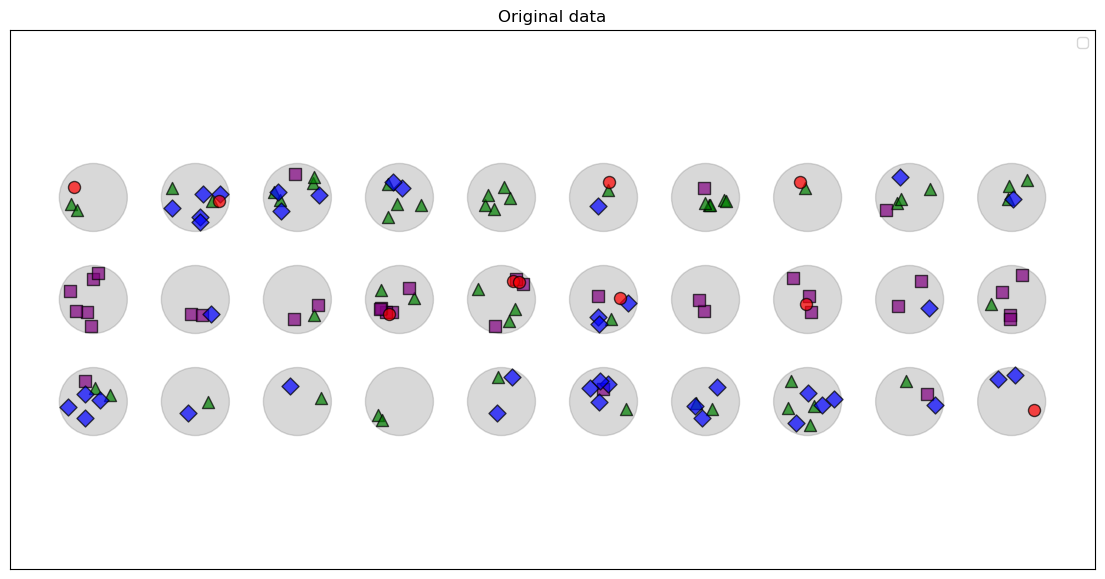

In [6]:
grid_size = (3, M)  # Rows and columns in the grid
ax = plot_bags_in_grid(X_sparse, grid_size, 0, (14,7))
ax.set_title('Original data')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

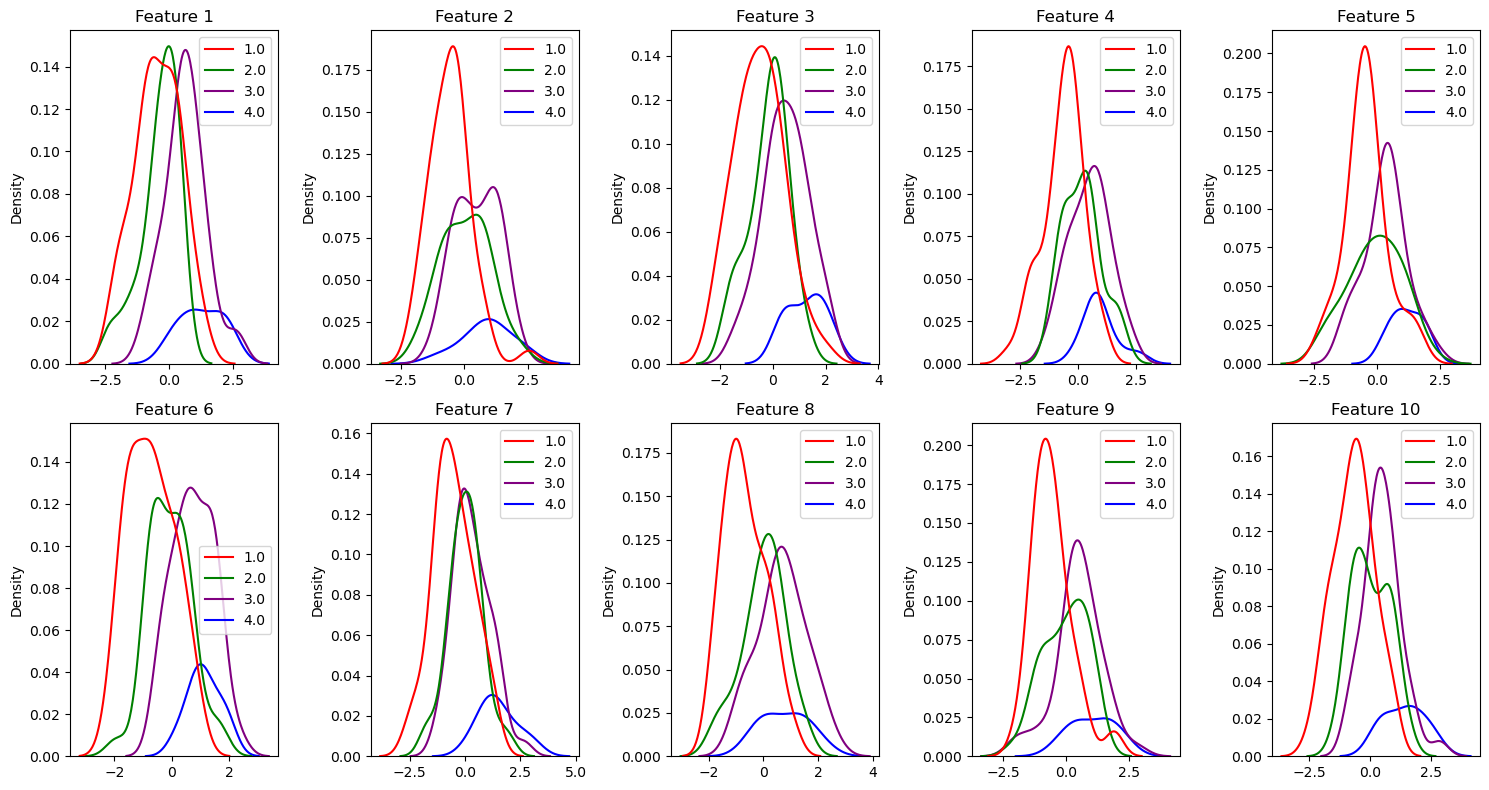

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()
for i in range(10):
    sns.kdeplot(x=B[:, i], hue=X, ax=axes[i], palette=['red','green', 'purple', 'blue'])
    axes[i].set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

## Run method

In [8]:
from celltype_permutation import hierarchical_permutations

In [9]:
X_global = hierarchical_permutations(A, X_perm, B)

--------------------------------------------------------------
M_spot	 Perm_1	 	 Perm_2	 CHI
--------------------------------------------------------------
0 	 3 		 1 	 3.900770321927484
1 	 168 		 1 	 3.6300295472726405
2 	 280 		 1 	 2.9421131856917806
3 	 15 		 1 	 4.330041925031382
4 	 1 		 1 	 -inf
5 	 6 		 6 	 -inf
6 	 6 		 1 	 1.5327506132874804
7 	 2 		 2 	 -inf
8 	 20 		 2 	 1.8299687052757376
9 	 4 		 1 	 2.228784356454522
10 	 1 		 1 	 -inf
11 	 3 		 1 	 1.2488318903506908
12 	 3 		 1 	 1.2516743981883316
13 	 168 		 1 	 3.8361287699103985
14 	 560 		 2 	 3.7678811191803923
15 	 120 		 2 	 1.895123310188657
16 	 1 		 1 	 -inf
17 	 4 		 1 	 1.6112825313817327
18 	 3 		 1 	 1.156859229073824
19 	 5 		 1 	 1.4848735641360078
20 	 105 		 1 	 2.339258583757316
21 	 2 		 2 	 -inf
22 	 2 		 2 	 -inf
23 	 1 		 1 	 -inf
24 	 3 		 1 	 5.796188369227154
25 	 30 		 2 	 2.139130942363262
26 	 10 		 1 	 2.7296890707565886
27 	 70 		 2 	 7.920237174158034
28 	 6 		 6 	 -inf
29 	 3 		 1 	 1

100%|██████████| 9216/9216 [00:04<00:00, 2089.61it/s]

Maximum Score: 12.599293925670187
Total time: 5.158239841461182


## Evaluate results

In [10]:
from sklearn.metrics import classification_report

In [11]:
print('BEFORE')
print(classification_report(X, X_perm))

BEFORE
              precision    recall  f1-score   support

         1.0       0.55      0.55      0.55        53
         2.0       0.58      0.58      0.58        36
         3.0       0.57      0.57      0.57        40
         4.0       0.20      0.20      0.20        10

    accuracy                           0.54       139
   macro avg       0.48      0.48      0.48       139
weighted avg       0.54      0.54      0.54       139



In [12]:
print('AFTER')
print(classification_report(X, X_global))

AFTER
              precision    recall  f1-score   support

         1.0       0.83      0.83      0.83        53
         2.0       0.69      0.69      0.69        36
         3.0       0.82      0.82      0.82        40
         4.0       0.80      0.80      0.80        10

    accuracy                           0.79       139
   macro avg       0.79      0.79      0.79       139
weighted avg       0.79      0.79      0.79       139

